<a href="https://colab.research.google.com/github/EvanM19/Projet-scoring/blob/main/discretization/tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature_selection and descriptive analysis



### Data and library importation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Markdown, display
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
samples = pd.read_excel('/content/drive/My Drive/samples.xlsx', sheet_name=None)

Mounted at /content/drive


In [74]:
colonnes_a_supprimer = [ 'id_client', 'CODTYPPRS', 'CRTOD_CMT_PRO_IND_0209','INDPARDCD','CRTOP_AG_IND_0038', 'CRTOP_IND_0038', 'CRTOU_CCT_PRO_IND_0209', 'DATCREENT', 'DATRLNORG', 'RATIO1', 'RATIO3', 'TOP_PRO_ACTIF', 'IND_ACTIF', 'IND_PER_PM', 'CODCMNIEE', 'CODPAY_NAISSANCE', 'CODPAY_NATIONALITE', 'CODPAY_RESIDENCE', 'CODSEXPRS', 'secteur_activite', 'secteur_activite_bis' ]

samples = samples
train = samples[list(samples.keys())[0]]
train = train.drop(columns=colonnes_a_supprimer)
test = samples[list(samples.keys())[1]]
test = test.drop(columns=colonnes_a_supprimer)
oot = samples[list(samples.keys())[2]]
oot = oot.drop(columns=colonnes_a_supprimer)
sample = pd.concat([train, test, oot], ignore_index=True)

### Preprocesing

In [75]:
#####Datehis

# print(sample['datdelhis'].unique())
sample['datdelhis'] = sample['datdelhis'] % 100
# print(sample['datdelhis'].unique())
sample['datdelhis'] = sample['datdelhis'].astype(str)

# observations_par_tranche = sample.groupby('datdelhis').size()
# observations_par_tranche.plot(kind='bar', color='skyblue')
# plt.title("Nombre d'observations par tranche de temps")
# plt.xlabel("Temps")
# plt.ylabel("Nombre d'observations")
# plt.xticks(rotation=45)
# plt.show()

quali=['DDefaut_NDB','datdelhis','AGEPRS','CODITDBDF_PRO','CODETAJUR','CODNAF2']


In [76]:
def discretize_supervised(data, target, features, n, min_fraction=0.3):
    discretized_columns = []
    total_samples = len(data)
    for feature in features:
        X = data[[feature]].values
        y = data[target].values

        clf = DecisionTreeClassifier(
            max_leaf_nodes=n,
            random_state=42,
            min_samples_split=0.05 ,
            # min_samples_leaf=int(total_samples * min_fraction)
        )
        clf.fit(X, y)

        thresholds = np.sort(clf.tree_.threshold[clf.tree_.threshold != -2])
        if len(thresholds) == 0:
            print(f"Skipping '{feature}' as it results in only one class.")
            continue

        # Définir une fonction pour affecter les classes
        def assign_class(value):
            for i, threshold in enumerate(thresholds):
                if value <= threshold:
                    return i
            return len(thresholds)

        # Appliquer la discrétisation
        discretized_column = data[feature].apply(assign_class)
        unique_classes = discretized_column.nunique()

        # Ajouter la colonne discrétisée au DataFrame
        column_name = f"{feature}_discretized"

        data[column_name] = discretized_column
        discretized_columns.append(column_name)

                # Appliquer la discrétisation 22222222222222
        discretized_column = sample[feature].apply(assign_class)
        sample[column_name] = discretized_column
        discretized_columns.append(column_name)

        # Afficher les informations
        print(f"Seuils de coupure pour '{feature}': {thresholds}")
        print(export_text(clf, feature_names=[feature]))

    return data, discretized_columns

def plot_discretized_classes(data, target, discretized_columns, date_col):
    for column in discretized_columns:
        # Groupement des données
        grouped = (
            data.groupby([date_col, column])[target]
            .mean()
            .reset_index()
            .rename(columns={target: 'Taux_de_defaut'})
        )

        # Pivot pour les modalités
        pivot_table = grouped.pivot(index=date_col, columns=column, values='Taux_de_defaut')

    # Création d'une nouvelle figure
    plt.figure(figsize=(10, 6))
    plt.plot(pivot_table, marker='o', linestyle='-')  #

    # Configuration du graphique
    plt.title(f"Taux de défaut pour '{column}'")
    plt.xlabel("Date")
    plt.ylabel("Taux de défaut")
    plt.grid()
    plt.legend(title=f"Classes de '{column}'")
    plt.tight_layout()



In [78]:
def f(x,y):
  train_discretized, discretized_cols = discretize_supervised(
      train, 'DDefaut_NDB', [x], n=y, min_fraction=0.05
  )
  plot_discretized_classes(train_discretized, 'DDefaut_NDB', discretized_cols, date_col='datdelhis')
  x=f"{x}_discretized"
  taux_defaut_temps = sample.groupby([x, "datdelhis"])["DDefaut_NDB"].mean().reset_index()


  # Tracer les courbes des taux de défaut par modalité au fil du temps
  plt.figure(figsize=(12, 8))
  sns.lineplot(x="datdelhis", y="DDefaut_NDB", hue=x, data=taux_defaut_temps, ci=None, marker='o')
  plt.title("Stabilité des modalités en taux au cours du temps")
  plt.xlabel("Temps (datdelhis)")
  plt.ylabel("Taux du critère")
  plt.grid(True)
  plt.legend(title="Modalité")
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  # Stabilité en volumétrie : effectif minimum de 5%
  modalites_count = sample[x].value_counts(normalize=True) * 100

  # Tracer la distribution des effectifs par modalité
  plt.figure(figsize=(10, 6))
  modalites_count.plot(kind="bar", color="skyblue")
  plt.title("Distribution des effectifs par modalité")
  plt.xlabel("Modalité (CODNAF2_grouped_name)")
  plt.ylabel("Effectif (%)")
  plt.grid(True)
  # plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  # Vérification du critère 3 : Effectif minimum de 5% par modalité
  min_effectif = 5  # pourcentage minimum acceptable
  modalites_filtres = modalites_count[modalites_count >= min_effectif]

  if len(modalites_filtres) == len(modalites_count):
      print(f"Critère 3 : Toutes les modalités ont un effectif supérieur ou égal à {min_effectif}%.")
  else:
      print(f"Critère 3 : Certaines modalités ont un effectif inférieur à {min_effectif}%.")

  # Critère 4 : Vérification de la séparation d'au moins 30% relatif entre modalités
  max_diff = taux_criteres.max() - taux_criteres.min()

  # Tracer les taux de défaut des modalités
  plt.figure(figsize=(10, 6))
  sns.barplot(x=taux_criteres.index, y=taux_criteres.values, color="lightcoral")
  plt.title("Différence entre les modalités en termes de taux de défaut")
  plt.xlabel(f"Modalité {x}")
  plt.ylabel("Taux du critère")
  # plt.xticks(rotation=45)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # Vérification du critère 4 : Séparation de 30% relatif
  separation_requise = 0.30  # 30% de séparation
  separation = max_diff / taux_criteres.max()

  if separation >= separation_requise:
      print(f"Critère 4 : Les modalités sont séparées d'au moins {separation_requise * 100}% en termes de taux de défaut.")
  else:
      print(f"Critère 4 : Les modalités ne sont pas séparées d'au moins {separation_requise * 100}% en termes de taux de défaut.")


Seuils de coupure pour 'CRTOC_IND_0015': [ 3.5 27.5]
|--- CRTOC_IND_0015 <= 27.50
|   |--- CRTOC_IND_0015 <= 3.50
|   |   |--- class: 0
|   |--- CRTOC_IND_0015 >  3.50
|   |   |--- class: 0
|--- CRTOC_IND_0015 >  27.50
|   |--- class: 0



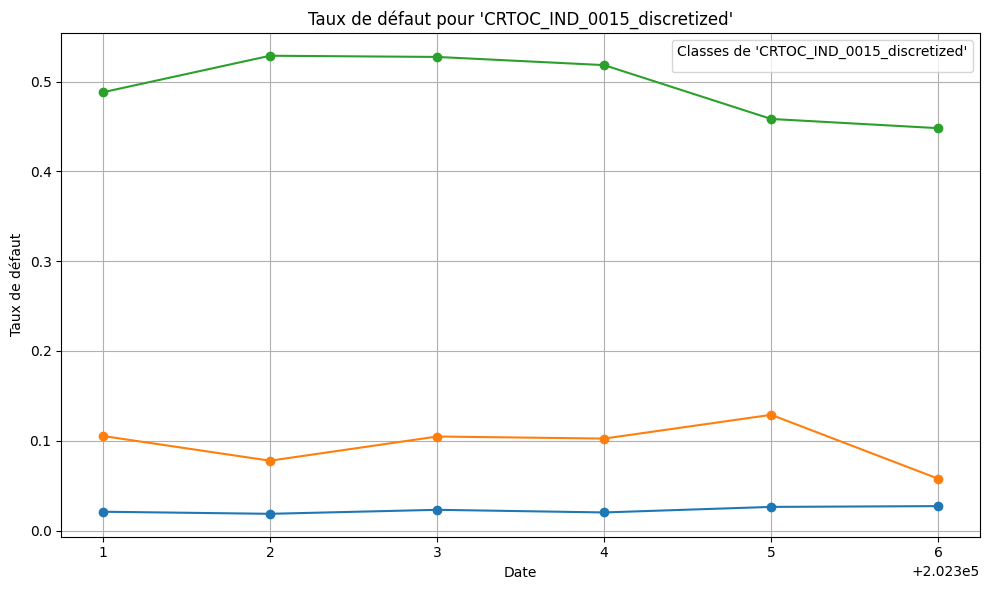

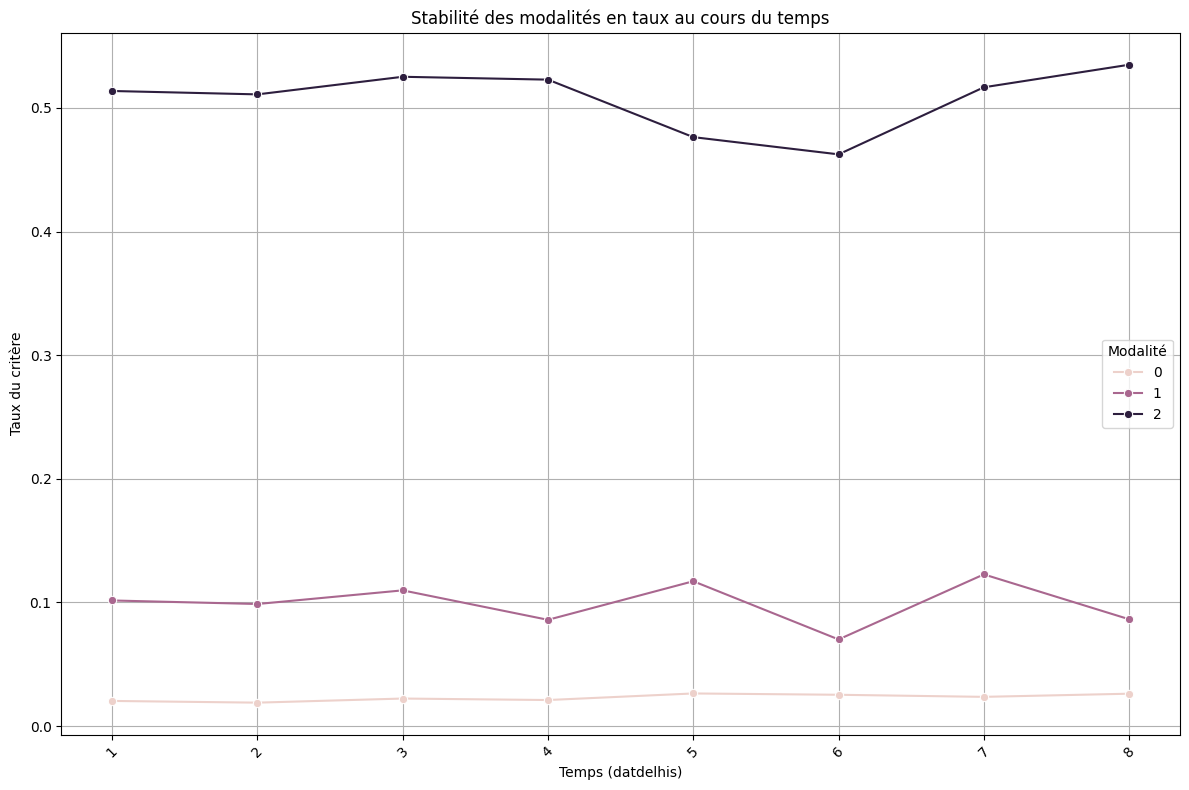

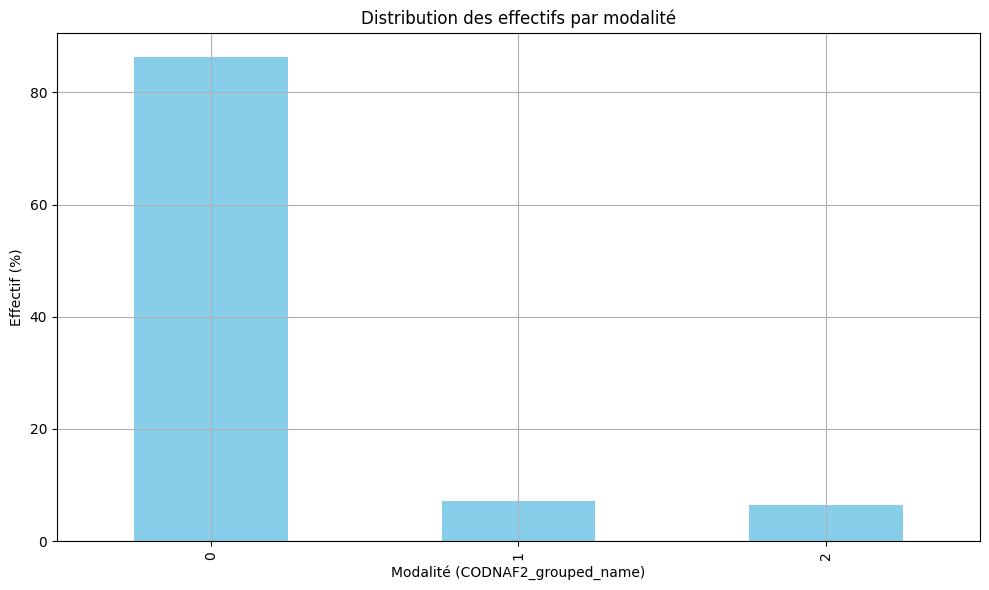

Critère 3 : Toutes les modalités ont un effectif supérieur ou égal à 5%.


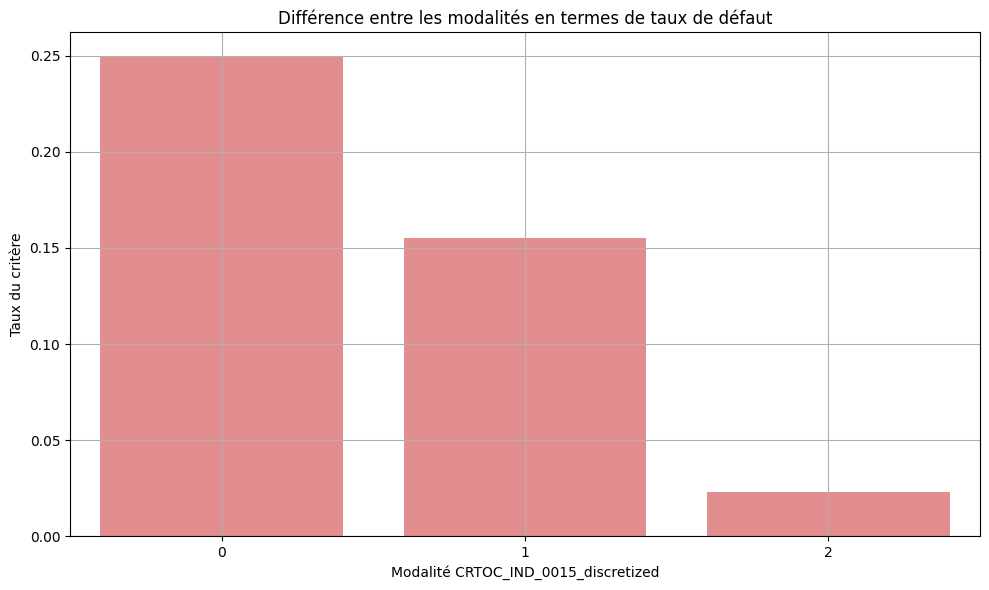

Critère 4 : Les modalités sont séparées d'au moins 30.0% en termes de taux de défaut.
Seuils de coupure pour 'CRTOC_AG_LIGDEB_2T_IND_0015': [-1422266.   -403533.5]
|--- CRTOC_AG_LIGDEB_2T_IND_0015 <= -403533.50
|   |--- CRTOC_AG_LIGDEB_2T_IND_0015 <= -1422266.00
|   |   |--- class: 0
|   |--- CRTOC_AG_LIGDEB_2T_IND_0015 >  -1422266.00
|   |   |--- class: 0
|--- CRTOC_AG_LIGDEB_2T_IND_0015 >  -403533.50
|   |--- class: 0



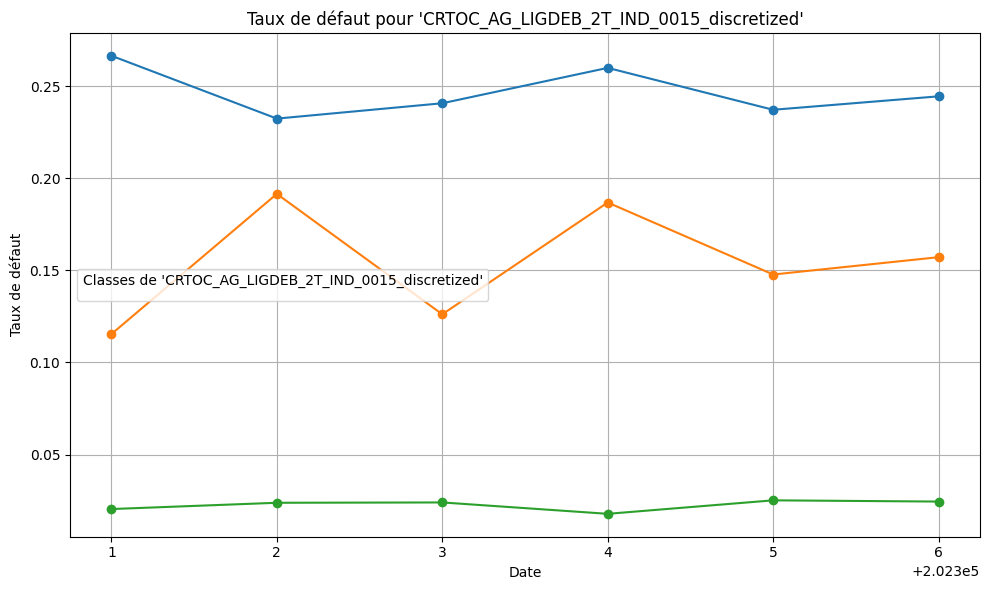

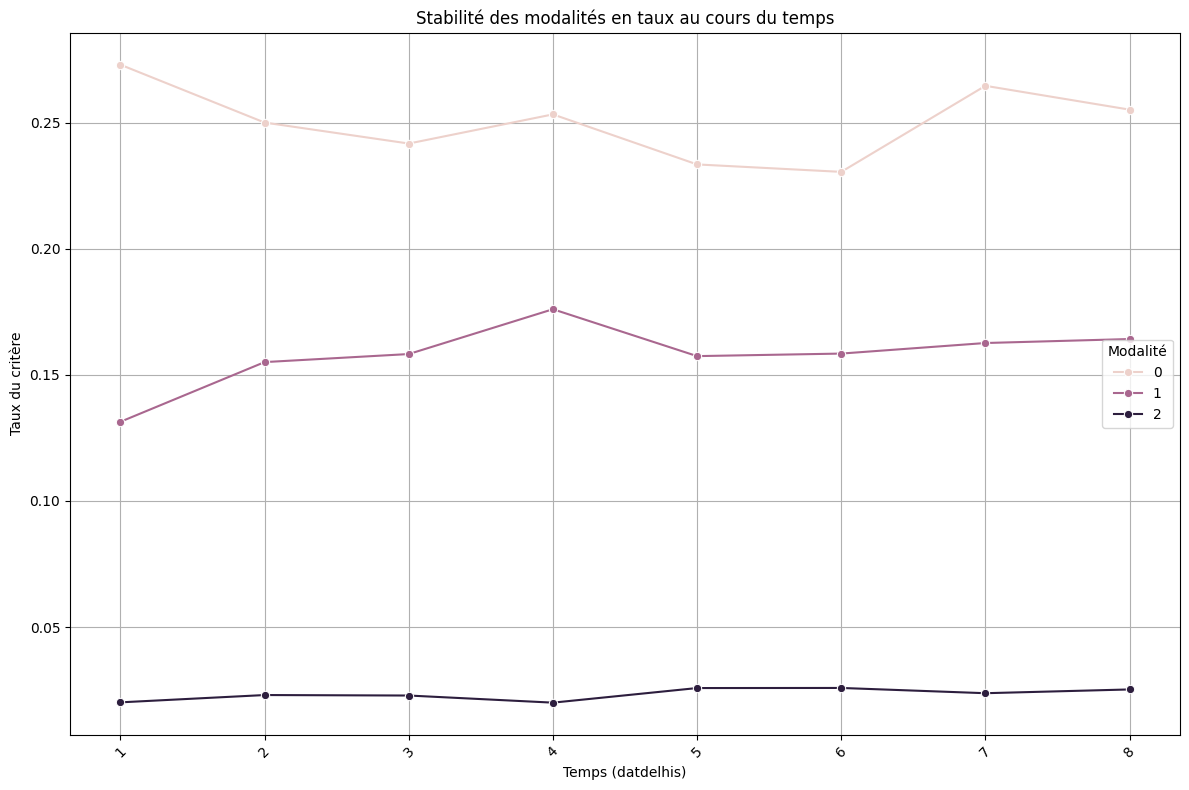

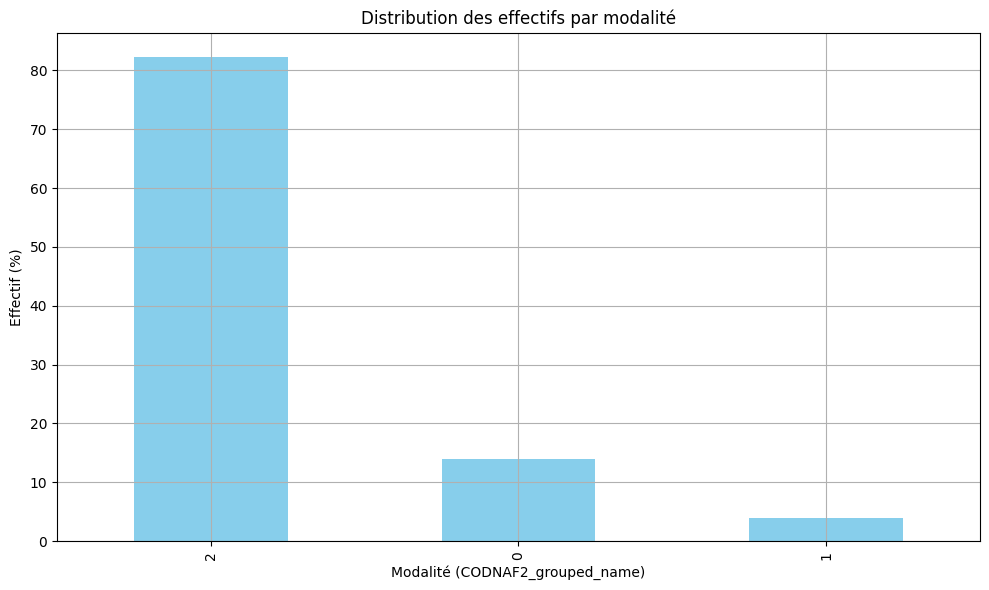

Critère 3 : Certaines modalités ont un effectif inférieur à 5%.


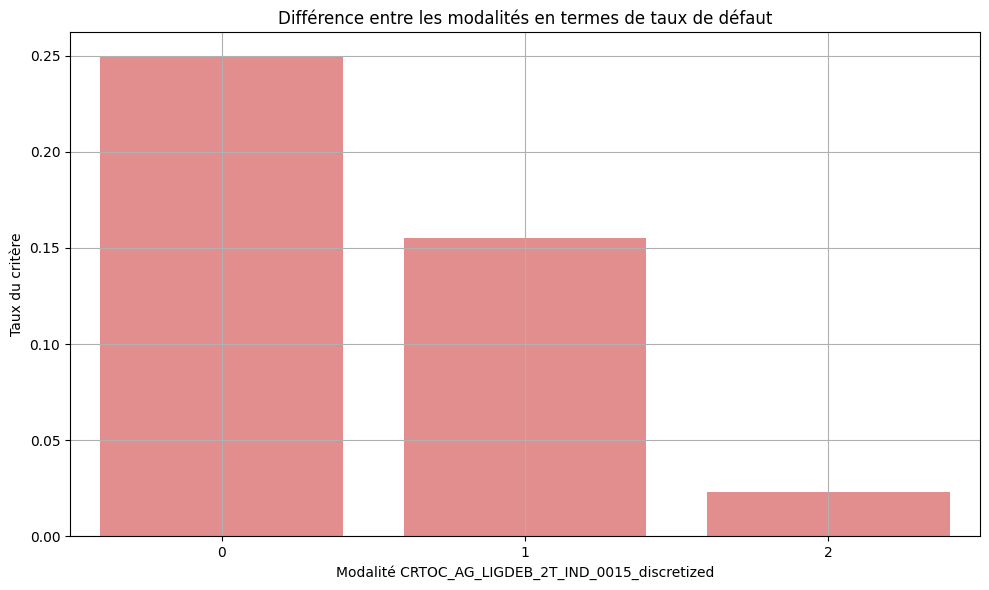

Critère 4 : Les modalités sont séparées d'au moins 30.0% en termes de taux de défaut.
Seuils de coupure pour 'CRTOC_IND_0164': [-192950.   -3950.   87250.]
|--- CRTOC_IND_0164 <= -3950.00
|   |--- CRTOC_IND_0164 <= -192950.00
|   |   |--- class: 0
|   |--- CRTOC_IND_0164 >  -192950.00
|   |   |--- class: 1
|--- CRTOC_IND_0164 >  -3950.00
|   |--- CRTOC_IND_0164 <= 87250.00
|   |   |--- class: 0
|   |--- CRTOC_IND_0164 >  87250.00
|   |   |--- class: 0



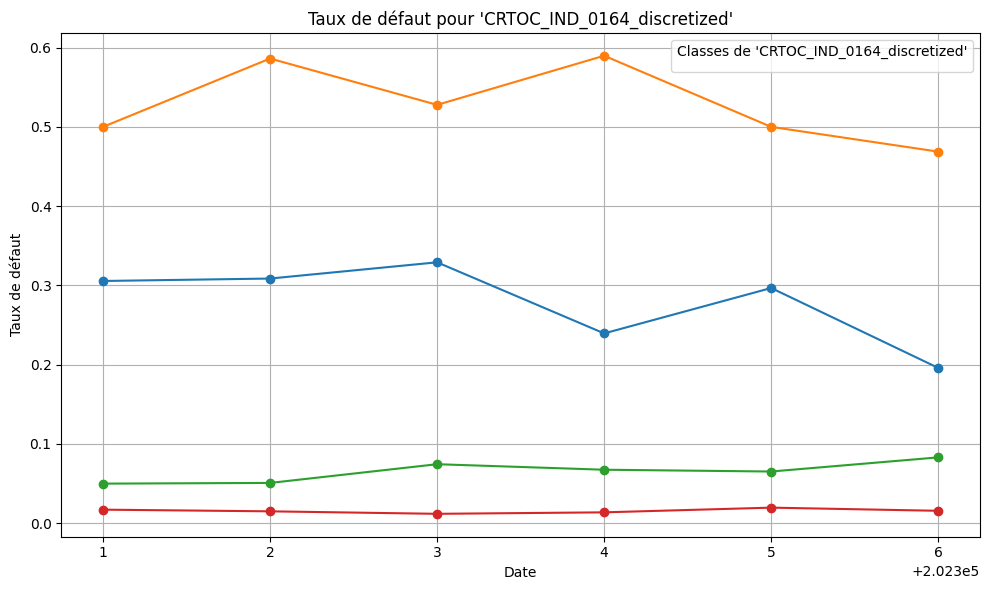

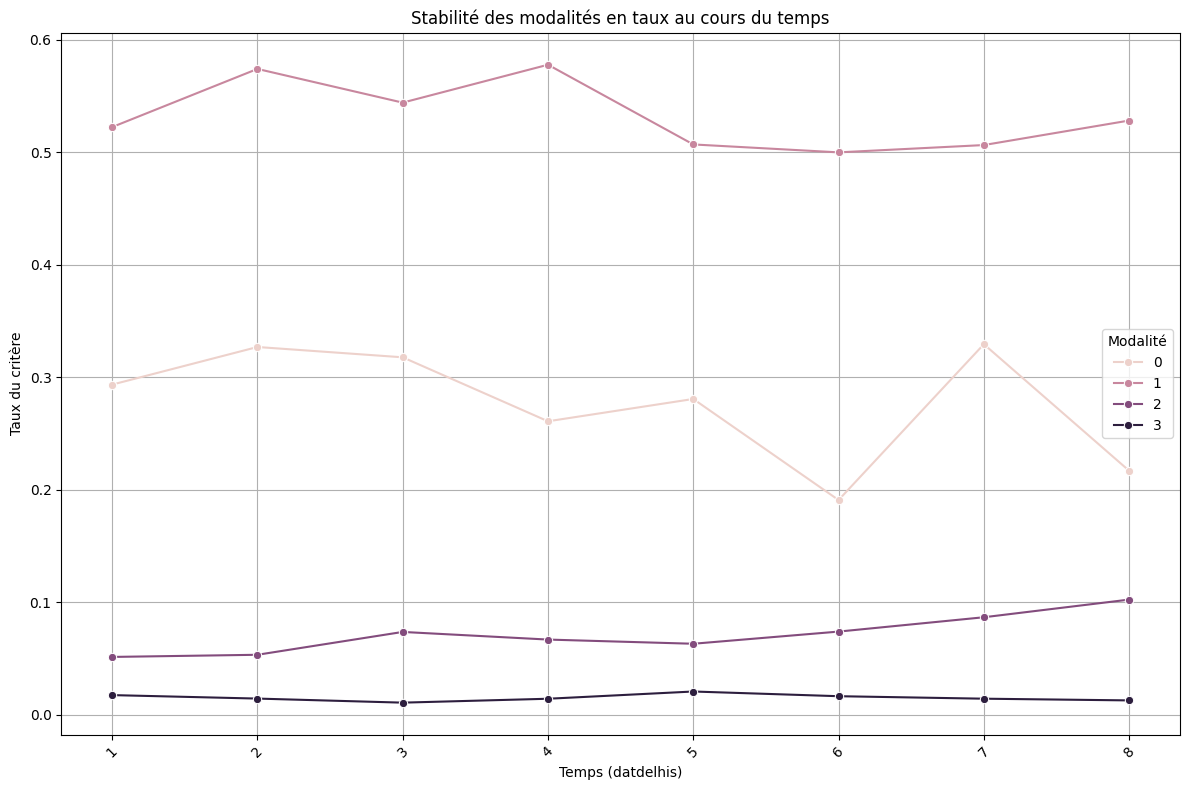

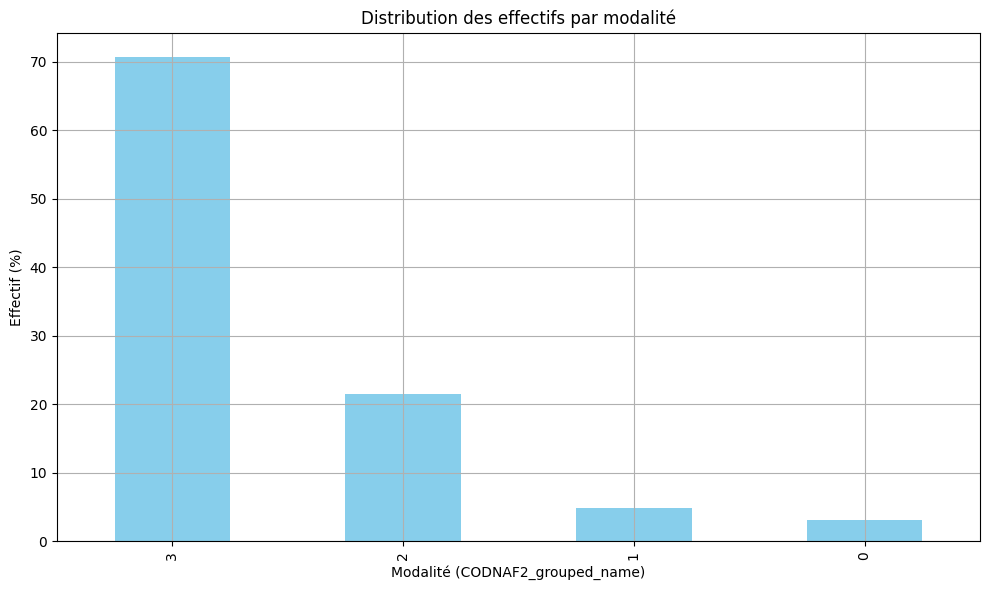

Critère 3 : Certaines modalités ont un effectif inférieur à 5%.


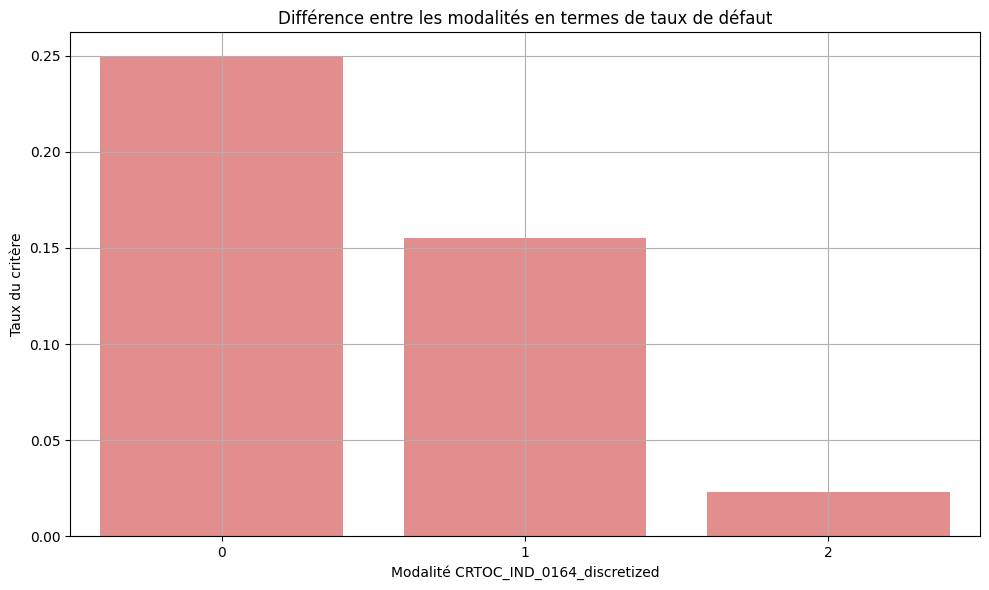

Critère 4 : Les modalités sont séparées d'au moins 30.0% en termes de taux de défaut.
Seuils de coupure pour 'CRTOC_AG_NBJCRE_2T_IND_0009': [ 11.5 134.5 180.5]
|--- CRTOC_AG_NBJCRE_2T_IND_0009 <= 11.50
|   |--- class: 0
|--- CRTOC_AG_NBJCRE_2T_IND_0009 >  11.50
|   |--- CRTOC_AG_NBJCRE_2T_IND_0009 <= 134.50
|   |   |--- class: 0
|   |--- CRTOC_AG_NBJCRE_2T_IND_0009 >  134.50
|   |   |--- CRTOC_AG_NBJCRE_2T_IND_0009 <= 180.50
|   |   |   |--- class: 0
|   |   |--- CRTOC_AG_NBJCRE_2T_IND_0009 >  180.50
|   |   |   |--- class: 0



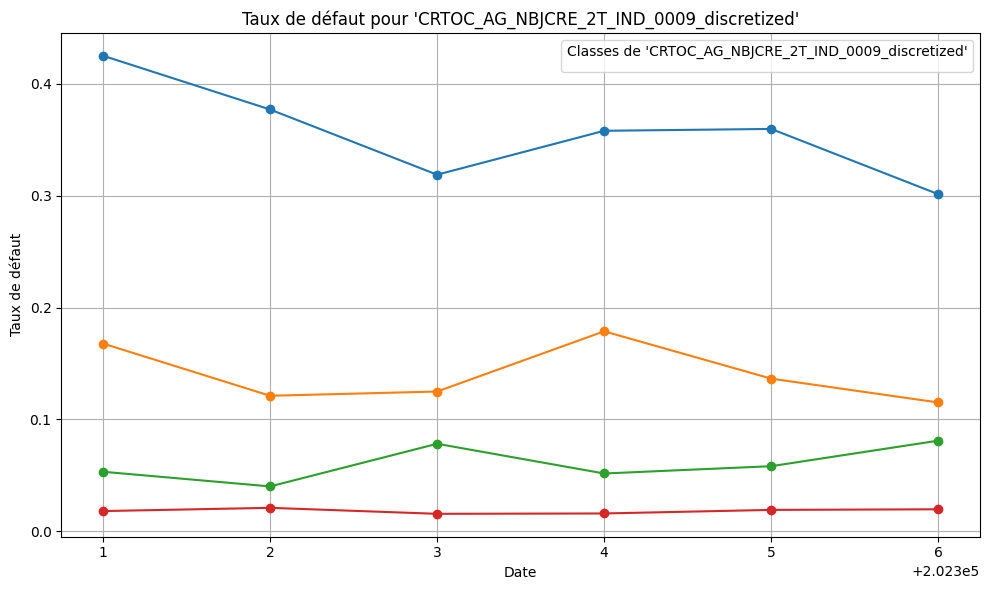

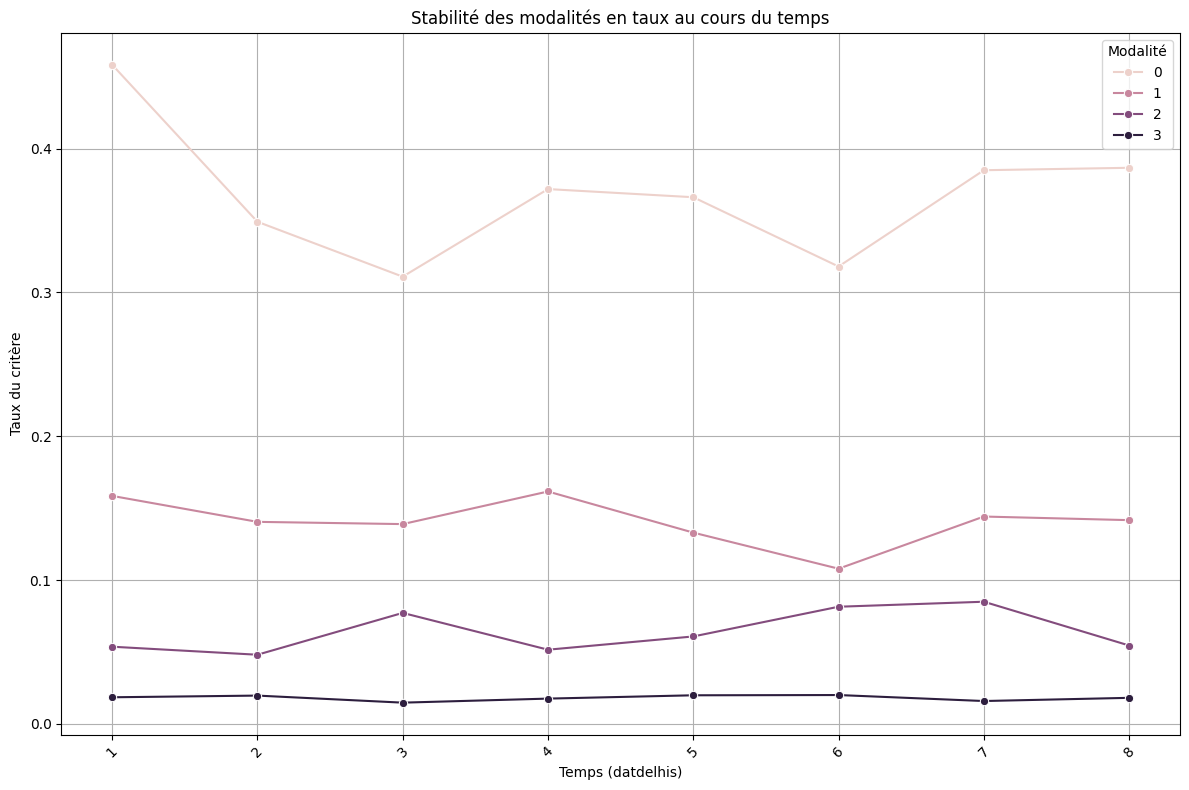

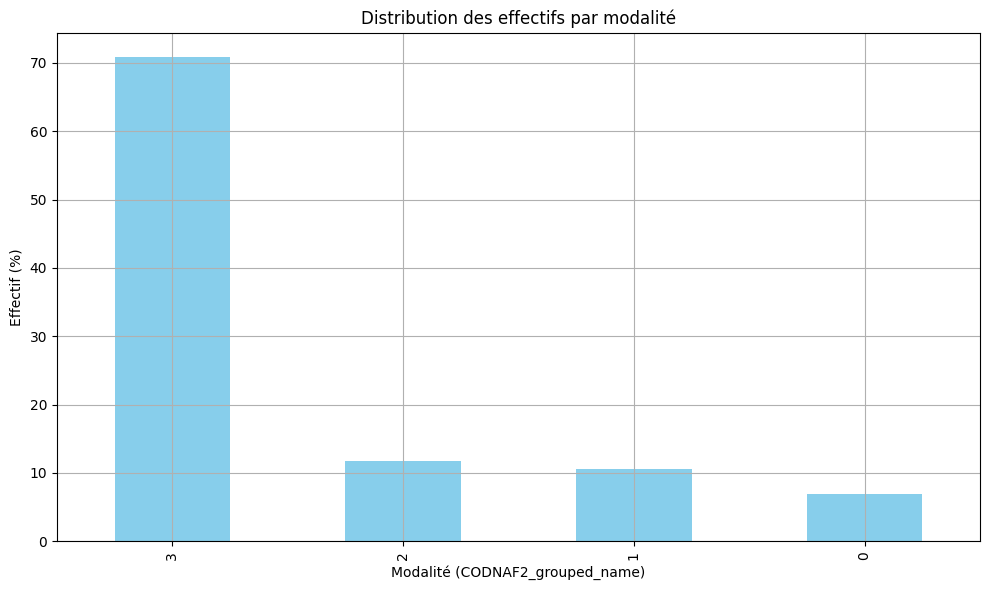

Critère 3 : Toutes les modalités ont un effectif supérieur ou égal à 5%.


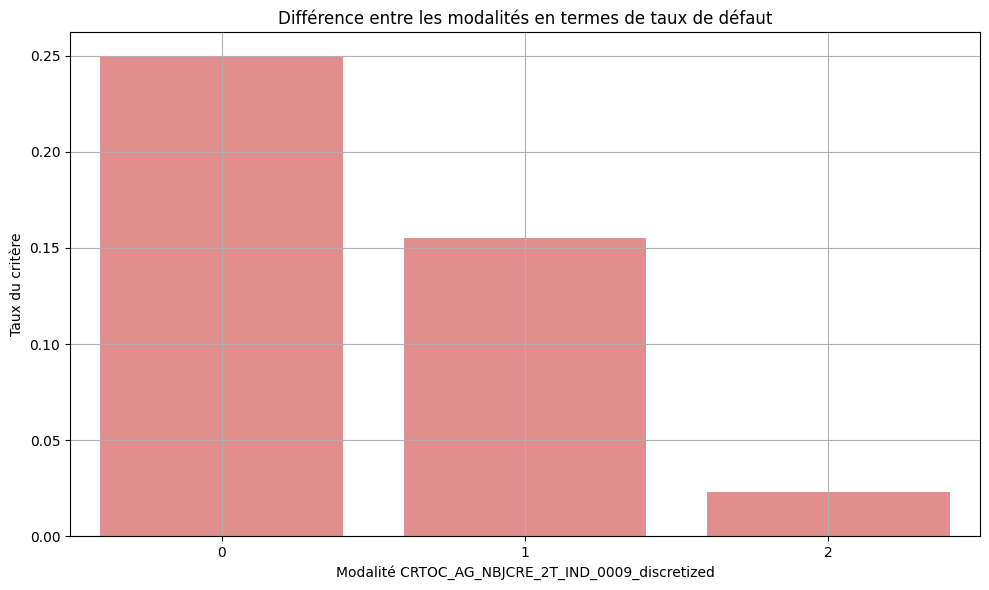

Critère 4 : Les modalités sont séparées d'au moins 30.0% en termes de taux de défaut.
Seuils de coupure pour 'CRTOC_AG_MVTAFF_2T_IND_0010': [  14156. 1811925.]
|--- CRTOC_AG_MVTAFF_2T_IND_0010 <= 14156.00
|   |--- class: 0
|--- CRTOC_AG_MVTAFF_2T_IND_0010 >  14156.00
|   |--- CRTOC_AG_MVTAFF_2T_IND_0010 <= 1811925.00
|   |   |--- class: 0
|   |--- CRTOC_AG_MVTAFF_2T_IND_0010 >  1811925.00
|   |   |--- class: 0



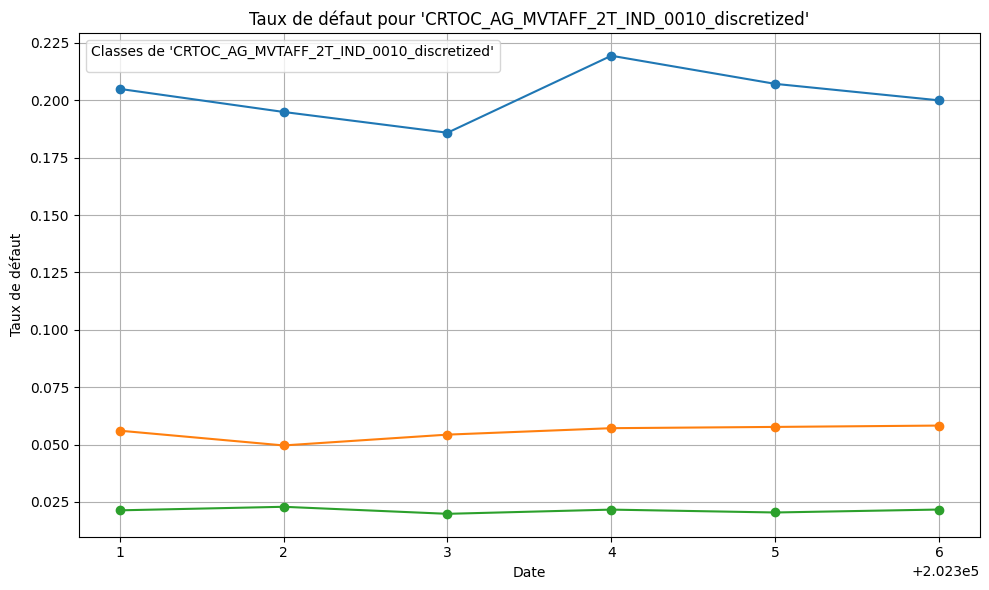

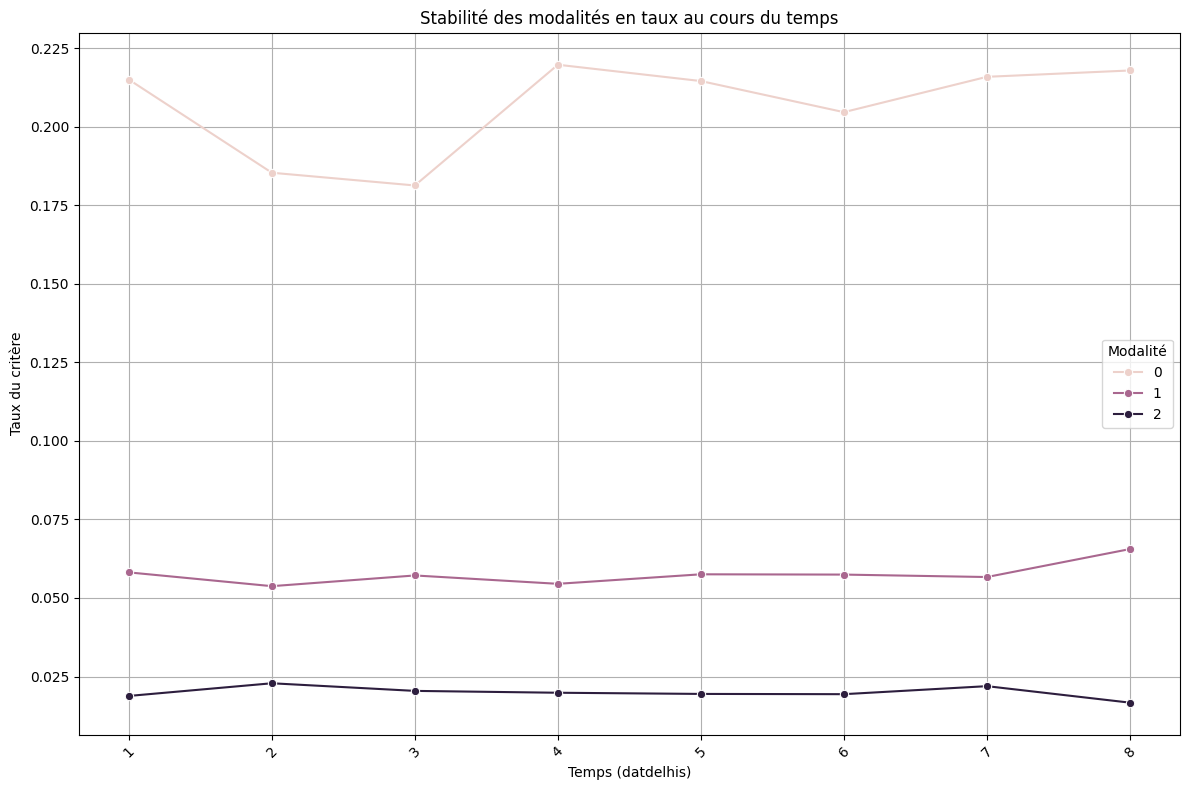

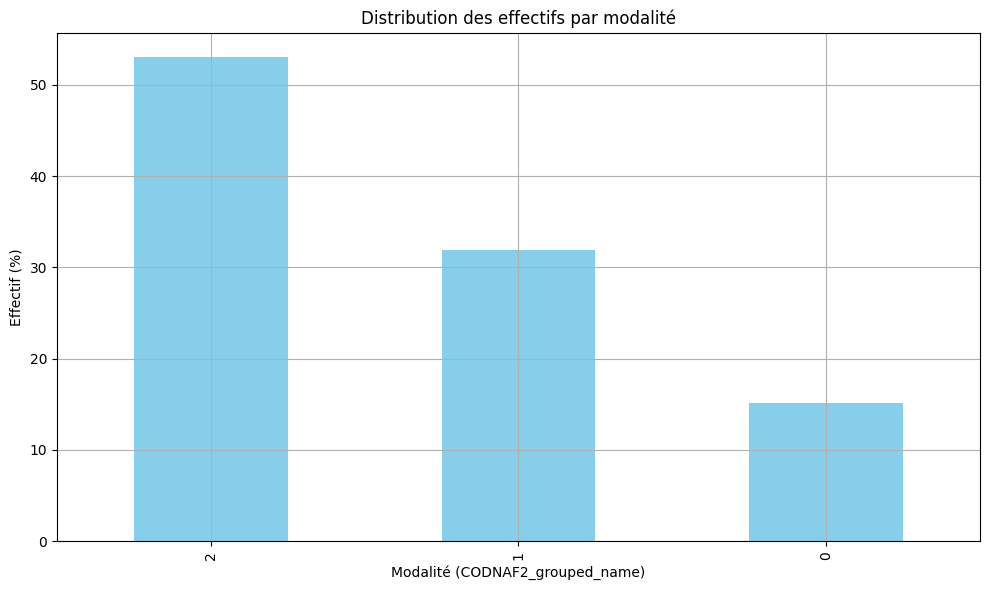

Critère 3 : Toutes les modalités ont un effectif supérieur ou égal à 5%.


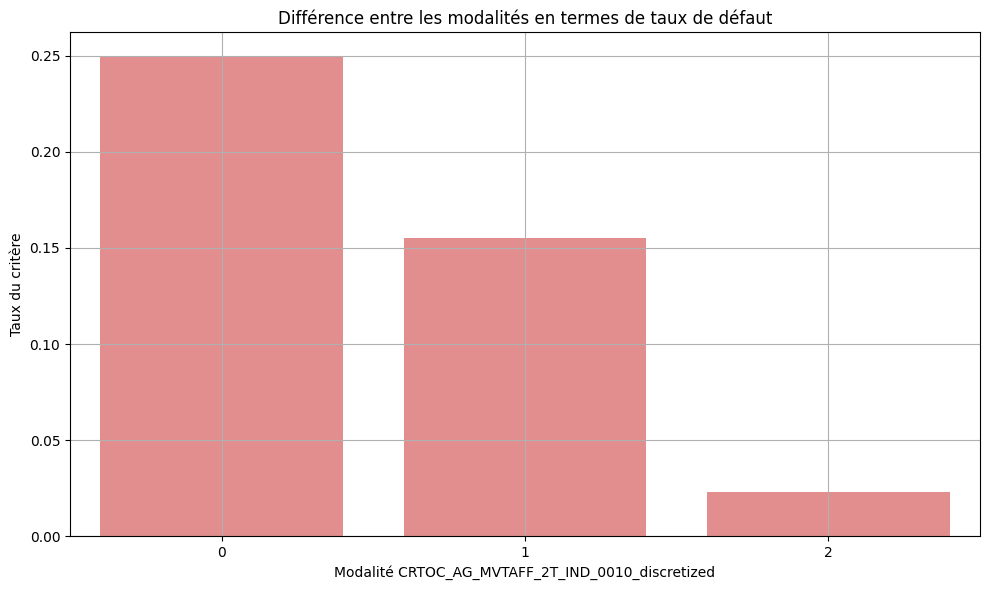

Critère 4 : Les modalités sont séparées d'au moins 30.0% en termes de taux de défaut.


In [79]:
quantitative_cols_after_wallis_pearson = ['CRTOC_IND_0015',3, 'CRTOC_AG_LIGDEB_2T_IND_0015',3, 'CRTOC_IND_0164',4,
    'CRTOC_AG_NBJCRE_2T_IND_0009',4, 'CRTOC_AG_MVTAFF_2T_IND_0010',3]
x=[quantitative_cols_after_wallis_pearson[(i*2)-1] for i in range(1, int(len(quantitative_cols_after_wallis_pearson)/2) + 1)]
nb_mod=[quantitative_cols_after_wallis_pearson[i*2] for i in range(int(len(quantitative_cols_after_wallis_pearson)/2))]

for i in range(len(x)):
  f(nb_mod[i],x[i])